In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import keras
from numpy import random

import tensorflow as tf

# import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
import np_utils
from keras.applications import MobileNet, VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report ,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-01-15 11:05:32.602982: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 11:05:32.653910: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 11:05:32.654969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 11:05:33.432653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
pip install np_utils

     |████████████████████████████████| 61 kB 76 kB/s  eta 0:00:011
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56450 sha256=1f534c31464f1d5341e0f982d72289658490b22498cb78bce30e9c42c70dd03f
  Stored in directory: /home/karunakar/.cache/pip/wheels/55/8b/e7/a23fd46c709c21e3e6fcb55978d88b018f80d54018459978c3
Successfully built np-utils
Note: you may need to restart the kernel to use updated packages.


* **Directory of dataset**

In [2]:
# Directory of train, validation and test

train_folder = "Data/train/"
valid_folder = "Data/valid/"
test_folder = "Data/test/"


In [3]:
input_shape = (224,224,3)
num_classes = 4

train_datagen = ImageDataGenerator(
    dtype='float32',
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    dtype='float32',

)
test_datagen = ImageDataGenerator(
    dtype='float32',
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    shuffle = False,
)
validation_generator = val_datagen.flow_from_directory(
    valid_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


# SERES_VGG16

* **Integrating the SE Block into the Residual Block and Incorporating it into the Last Two Output Layers of a Pre-trained VGG16 Model**

In [4]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, GlobalAveragePooling2D, Reshape, Multiply

def squeeze_excitation_block(input, ratio=16):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def residual_block(x, filters, kernel_size, stride):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = squeeze_excitation_block(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

input_tensor = Input(shape=(224, 224, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = vgg16.layers[-1].output
x = residual_block(x, 512, 3, 1)
x = residual_block(x, 512, 3, 1)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predictions)
# model.summary()

optimizer = tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 149
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)

Epoch 1/149


2025-01-15 11:06:15.773256: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.
2025-01-15 11:06:16.436173: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.
2025-01-15 11:06:17.416323: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-01-15 11:06:17.884735: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-01-15 11:06:39.233338: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


10/10 [==============================] - 375s 37s/step - loss: 1.4007 - accuracy: 0.4290 - val_loss: 14.9408 - val_accuracy: 0.2778
Epoch 2/149
10/10 [==============================] - 368s 36s/step - loss: 1.2858 - accuracy: 0.4747 - val_loss: 9.6120 - val_accuracy: 0.1806
Epoch 3/149
10/10 [==============================] - 376s 38s/step - loss: 1.0679 - accuracy: 0.5367 - val_loss: 6.2124 - val_accuracy: 0.1806
Epoch 4/149
10/10 [==============================] - 402s 40s/step - loss: 0.9161 - accuracy: 0.5824 - val_loss: 1.4620 - val_accuracy: 0.4306
Epoch 5/149
10/10 [==============================] - 388s 39s/step - loss: 0.7987 - accuracy: 0.6411 - val_loss: 3.3973 - val_accuracy: 0.2361
Epoch 6/149
10/10 [==============================] - 402s 40s/step - loss: 0.7196 - accuracy: 0.6966 - val_loss: 2.3173 - val_accuracy: 0.2639
Epoch 7/149
10/10 [==============================] - 387s 38s/step - loss: 0.6783 - accuracy: 0.7064 - val_loss: 2.0276 - val_accuracy: 0.3889
Epoch 8/14

In [5]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)

5/5 [==============================] - 49s 10s/step - loss: 0.2501 - accuracy: 0.9460
Test accuracy: 0.9460317492485046


5/5 [==============================] - 53s 11s/step


Confusion Matrix:
 [[106   3   3   8]
 [  0  50   0   1]
 [  1   0  53   0]
 [  0   0   1  89]]


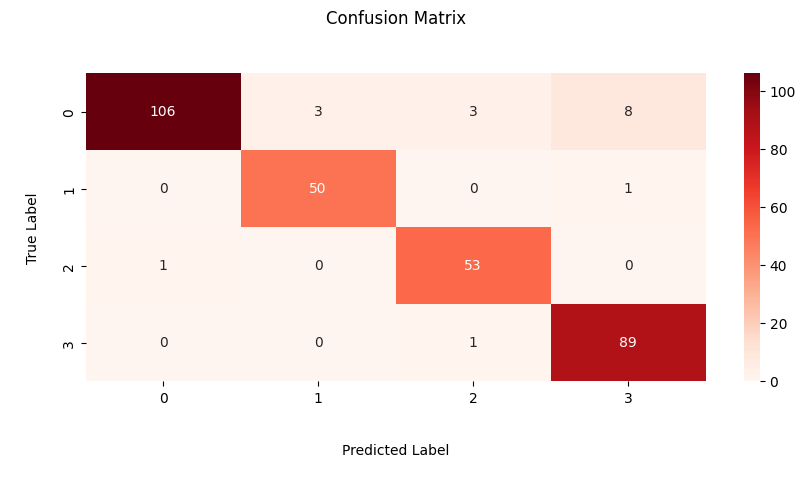

In [6]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)
predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
true_labels = test_generator.classes
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

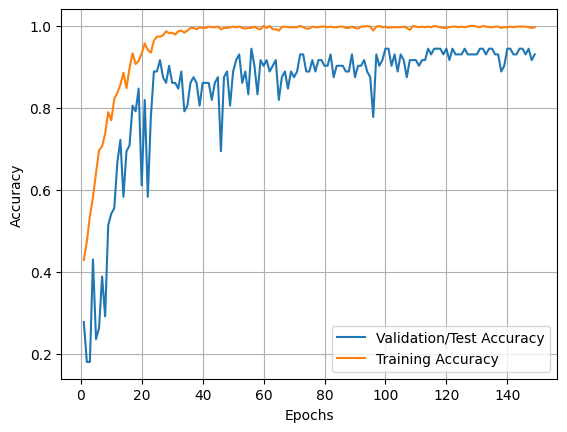

In [7]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

# plt.setp(line1)
# plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

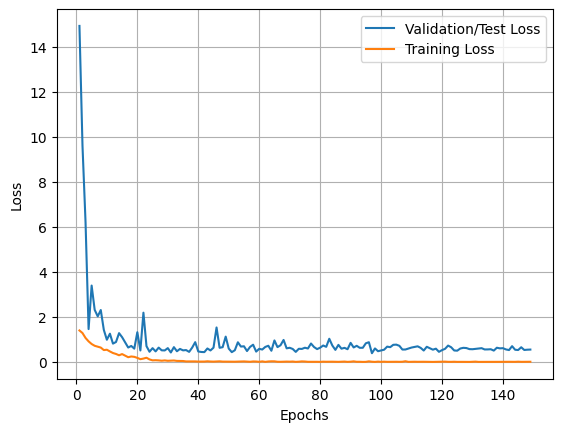

In [8]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

# plt.setp(line1)
# plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       120
           1       0.94      0.98      0.96        51
           2       0.93      0.98      0.95        54
           3       0.91      0.99      0.95        90

    accuracy                           0.95       315
   macro avg       0.94      0.96      0.95       315
weighted avg       0.95      0.95      0.95       315

